In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os


In [2]:
if not os.path.exists('./preprocessed'):
    os.makedirs('./preprocessed')

## Table of Contents:
* [Initial Screening and Cleaning](#first-bullet)
* [Feature Selection](#second-bullet)
* [Variable Relationships](#third-bullet)
* [Categorical Representation](#fourth-bullet)
* [Further Exploration of Output Data](#fifth-bullet)
* [Saving Data](#sixth-bullet)

## Preprocessing 
This notebook preprocess the data given for the spark ML Engineer Tech Test. 
This notebook was executed through using $\textbf{Papermill}$.

Pipelines can also be setup through $\textbf{snakemake}$

### Comments
Because there is no provided documentation about the data (which is 99% of the case with my work), 
there were several assumptions / decisions that I made with the data. In many applications, I'd explore the
data in a bit more detail here, but to speed things up I've made some educated assumptions. 

1. Complex features such as amenities, were removed from the analysis, this is primarily because some
    owners are perhaps more likely to document everything rather than others, this could be misleading. This conclusion was reached by investigation.  
2. Data was cleaned so that nan values were removed, this results in the removal of some features.
3. Features like "availibility_60" and so on were not used, this is primarily because what if the house had not been rented for a long time, data could be bad. 
4. Feature like latitude and longitude - neighbourhood classes capture this information.
5. Host specific information was removed, as it likely has a weak effect on the outcome.
6. Review scores are used as a feature, but have some limitation as newer houses will have fewer reviews. 

## Initial Screening <a class="anchor" id="first-bullet"></a>
Here, we will briefly screen the features within the data. 


We will select features based on several criteria such as the number of missing values, 
unique values and the overall cleanliness of the data

In [3]:
df = pd.read_csv(r'./Spark 64 ML Engineer Tech Test Dataset.csv', low_memory = False)
# I tend to prefer to use dask, or xarray due to using large datasets and paralelization, however for exploration I'll use pandas
#df = dd.read_csv(r'./Spark 64 ML Engineer Tech Test Dataset.csv')


In [4]:
print(f"Total number of features :{len(df.columns)}")

Total number of features :63


In [5]:
print(df.columns)

Index(['name', 'description', 'neighborhood_overview', 'host_id', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'n

### Determining the Number of Invalid Values in Data
This step easily enables us to determine what columns to remove, as we require enough training data for our model.

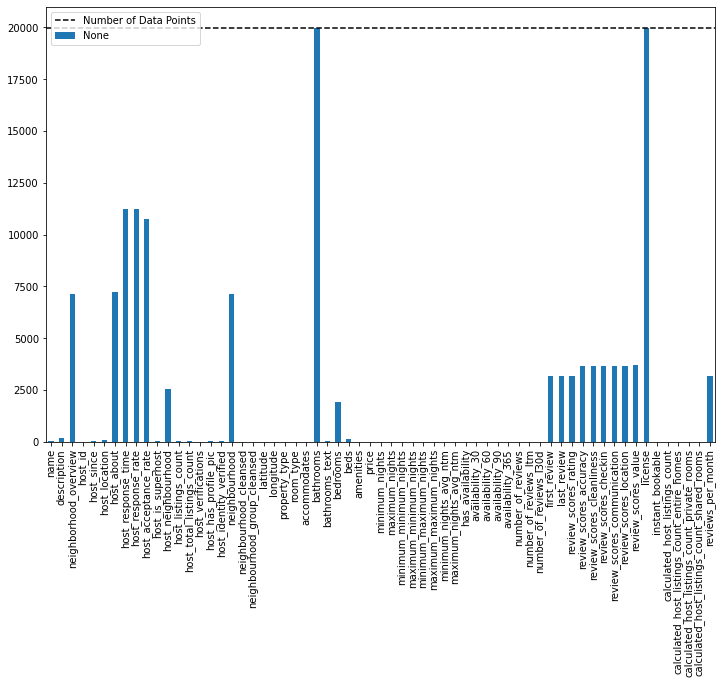

In [6]:
fig, ax = plt.subplots(figsize =(12,8))
df.isnull().sum().plot.bar(ax = ax)
ax.axhline(len(df), color ='k', ls ='--', label ='Number of Data Points')
ax.legend()

## Checking for the number of Unique values
While regression based variables have many unique values, if a categorical model has too many values it 
can be a challenge to learn relationships between that particular variable. Given that we have a limited amount of training data
we probably want to use variables with fewer categories

(0.0, 500.0)

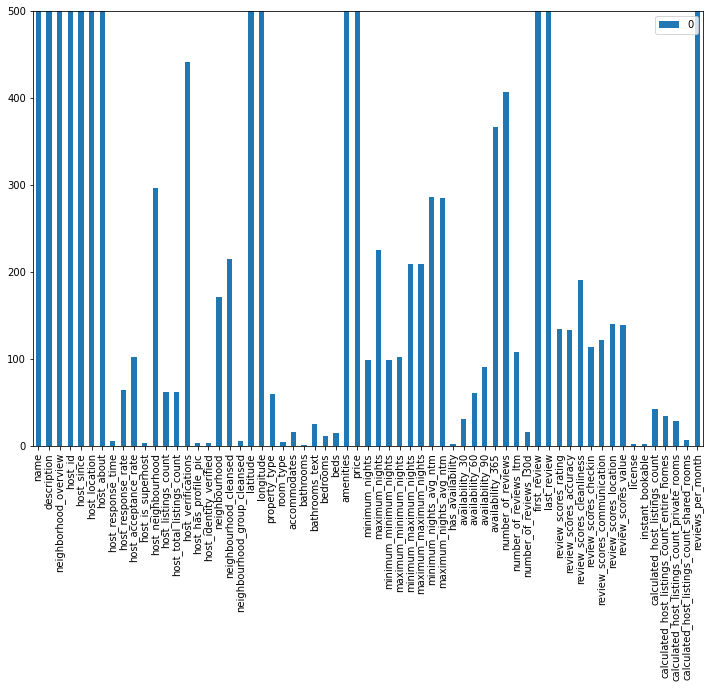

In [7]:
unique_numbers = [len(pd.unique(df[col])) for col in df.columns]
fig, ax = plt.subplots(figsize =(12,8))
df_unique = pd.DataFrame(data = unique_numbers, index = df.columns)
df_unique.plot.bar(ax = ax)
ax.set_ylim(0, 500)

In [8]:
df.columns

Index(['name', 'description', 'neighborhood_overview', 'host_id', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'n

# Feature Selection <a class="anchor" id="second-bullet"></a>
Here is the part where we decide what features to keep and use. The following is a list of features that I've decided to keep. 
Note this is the $\textbf{first cut}$ of the feature selection.
## Comments
1. Neighbour will be an important predictor. Here you can see that there are too many unique values, even neighbourhood cleansed has lots of unique values. In this scenario, we will remove neighbour hood cleansed - with 200 + values, and use neighbourhood_group_cleansed. Too many suburbs could cause the model to poorly generalize. 
2. Don't fully understand the minimum maximum nights features, so I'll remove them from the predictor dataset. Minimum_nights_av_ntm could be useful, as long term stays tend to pay less. 
3

C:\Users\user\anaconda3\envs\spark64\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 200.0)

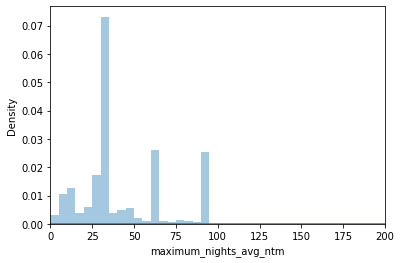

In [9]:
# Leveraging some features such as maximum nights avg_ntm could be challenging due its complex distribution
# This is primarily due the peak at 1,2 and 3 months
fig, ax = plt.subplots()
sns.distplot(df['maximum_nights_avg_ntm'], ax = ax, bins = np.arange(0,100,5))
ax.set_xlim(0,200)

C:\Users\user\anaconda3\envs\spark64\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 200.0)

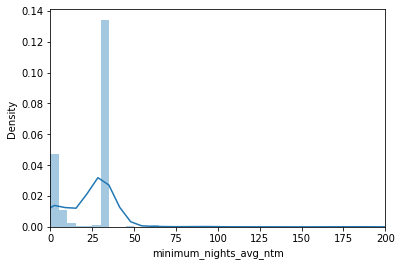

In [10]:
fig, ax = plt.subplots()
sns.distplot(df['minimum_nights_avg_ntm'], ax = ax, bins = np.arange(0,100,5))
ax.set_xlim(0,200)

In [11]:
pd.value_counts(df.bathrooms_text)
# there are some differences between shared and half baths here, which prompts more investigation.
# This likely indicates that this might not be the best variable - also given that there are few outside the first class

1 bath               11383
1 shared bath         4681
2 baths               1101
1 private bath         987
1.5 baths              583
1.5 shared baths       363
2 shared baths         361
2.5 baths              174
3 baths                 82
3.5 baths               38
Half-bath               29
2.5 shared baths        29
0 shared baths          28
0 baths                 25
3 shared baths          25
4 shared baths          17
4 baths                 14
4.5 baths               12
Shared half-bath         8
Private half-bath        7
5 baths                  5
6 baths                  2
3.5 shared baths         2
5.5 baths                1
Name: bathrooms_text, dtype: int64

In [12]:
# Property type would be another useful variables - this requires a bit of cleaning up, defining into other categories (e.g. Hotel)
pd.value_counts(df.property_type)

Entire rental unit                     8760
Private room in rental unit            6636
Private room in residential home       1056
Entire residential home                 603
Entire condominium (condo)              462
Private room in townhouse               438
Entire loft                             396
Entire townhouse                        333
Shared room in rental unit              225
Private room in condominium (condo)     203
Private room in loft                    188
Entire guest suite                      142
Entire serviced apartment               109
Room in boutique hotel                   58
Room in hotel                            52
Private room in guest suite              41
Entire place                             34
Room in serviced apartment               23
Private room                             22
Entire guesthouse                        19
Private room in hostel                   19
Private room in resort                   17
Shared room in loft             

In [13]:
# Property type would be another useful variables - this requires a bit of cleaning up, defining into other categories (e.g. Hotel)
pd.value_counts(df.room_type)

Entire home/apt    10908
Private room        8740
Shared room          274
Hotel room            77
Name: room_type, dtype: int64

In [14]:
categorical_variables = ['host_identity_verified','accommodates','bathrooms_text',
        'room_type','bedrooms','beds','instant_bookable',
        'neighbourhood_group_cleansed',
        'host_has_profile_pic',
        'host_response_time',
        'host_is_superhost']
regression_variables = ['review_scores_rating',
        'review_scores_accuracy','review_scores_cleanliness', 
        'review_scores_checkin','review_scores_communication',
        'review_scores_location',
       'review_scores_value','host_response_rate','host_acceptance_rate']
output_variable =['price']
print(f"number of categorical features : {len(categorical_variables)}, \n"\
      f"number of regression variables : {len(regression_variables)}")

number of categorical features : 11, 
number of regression variables : 9


C:\Users\user\anaconda3\envs\spark64\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 200.0)

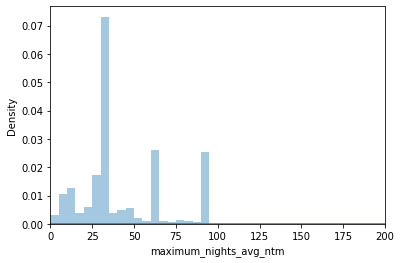

In [15]:
fig, ax = plt.subplots()
sns.distplot(df['maximum_nights_avg_ntm'], ax = ax, bins = np.arange(0,100,5))
ax.set_xlim(0,200)

# Variable Relationships <a class="anchor" id="third-bullet"></a>
While each of the reviews clearly has its own value, there are correlations between the input and outputs of the data. 
Multi-colinearity is an issue for Linear Regression, and require a normalization / dimensionality reduction strategy for this. 
RandomForest models should be okay to handle this data by itself (the distributions are not normal), so I'm not going to use dimensionality reduction here - but it could be useful.

<AxesSubplot:>

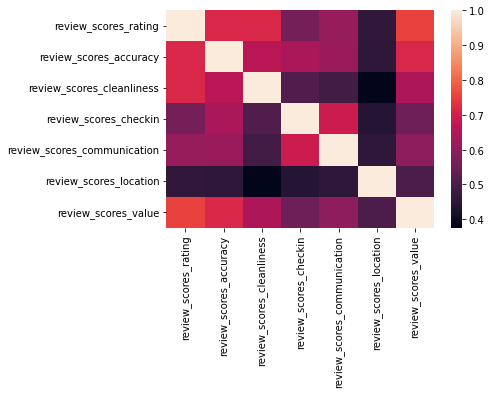

In [16]:
sns.heatmap(df[regression_variables].corr())

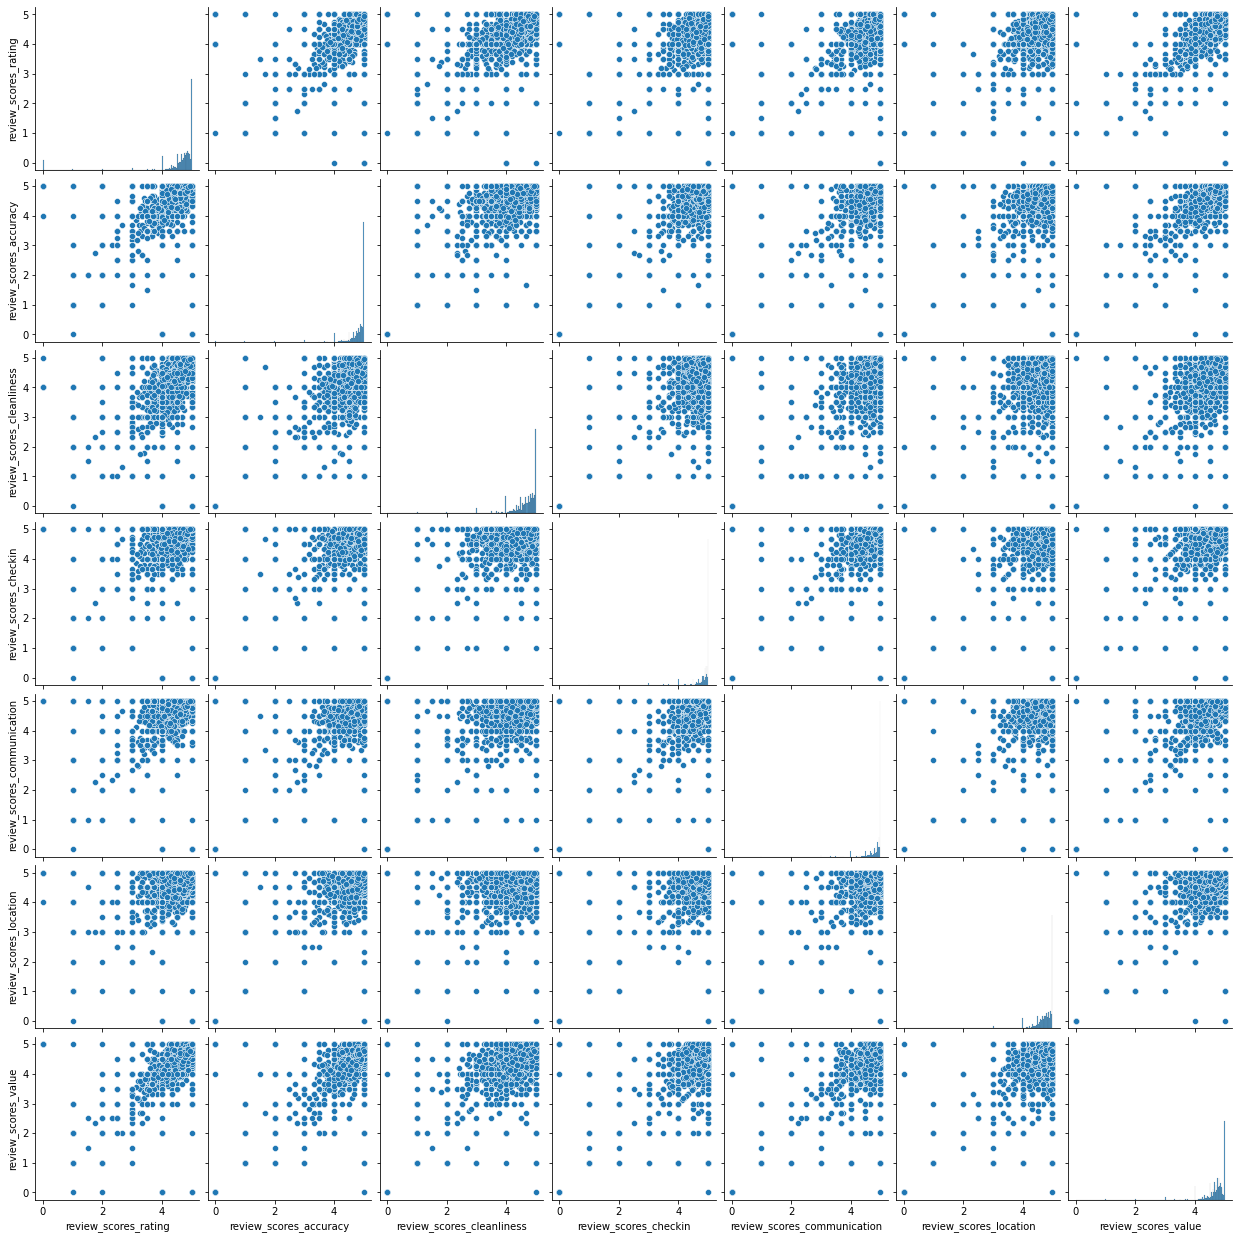

In [17]:
sns.pairplot(df[['review_scores_rating',
        'review_scores_accuracy','review_scores_cleanliness', 
        'review_scores_checkin','review_scores_communication',
        'review_scores_location',
       'review_scores_value']])

# Exploration of a potential transform of the data to help prediction
This normalization is as follows:
$ y = \log(5 - x +\delta)$

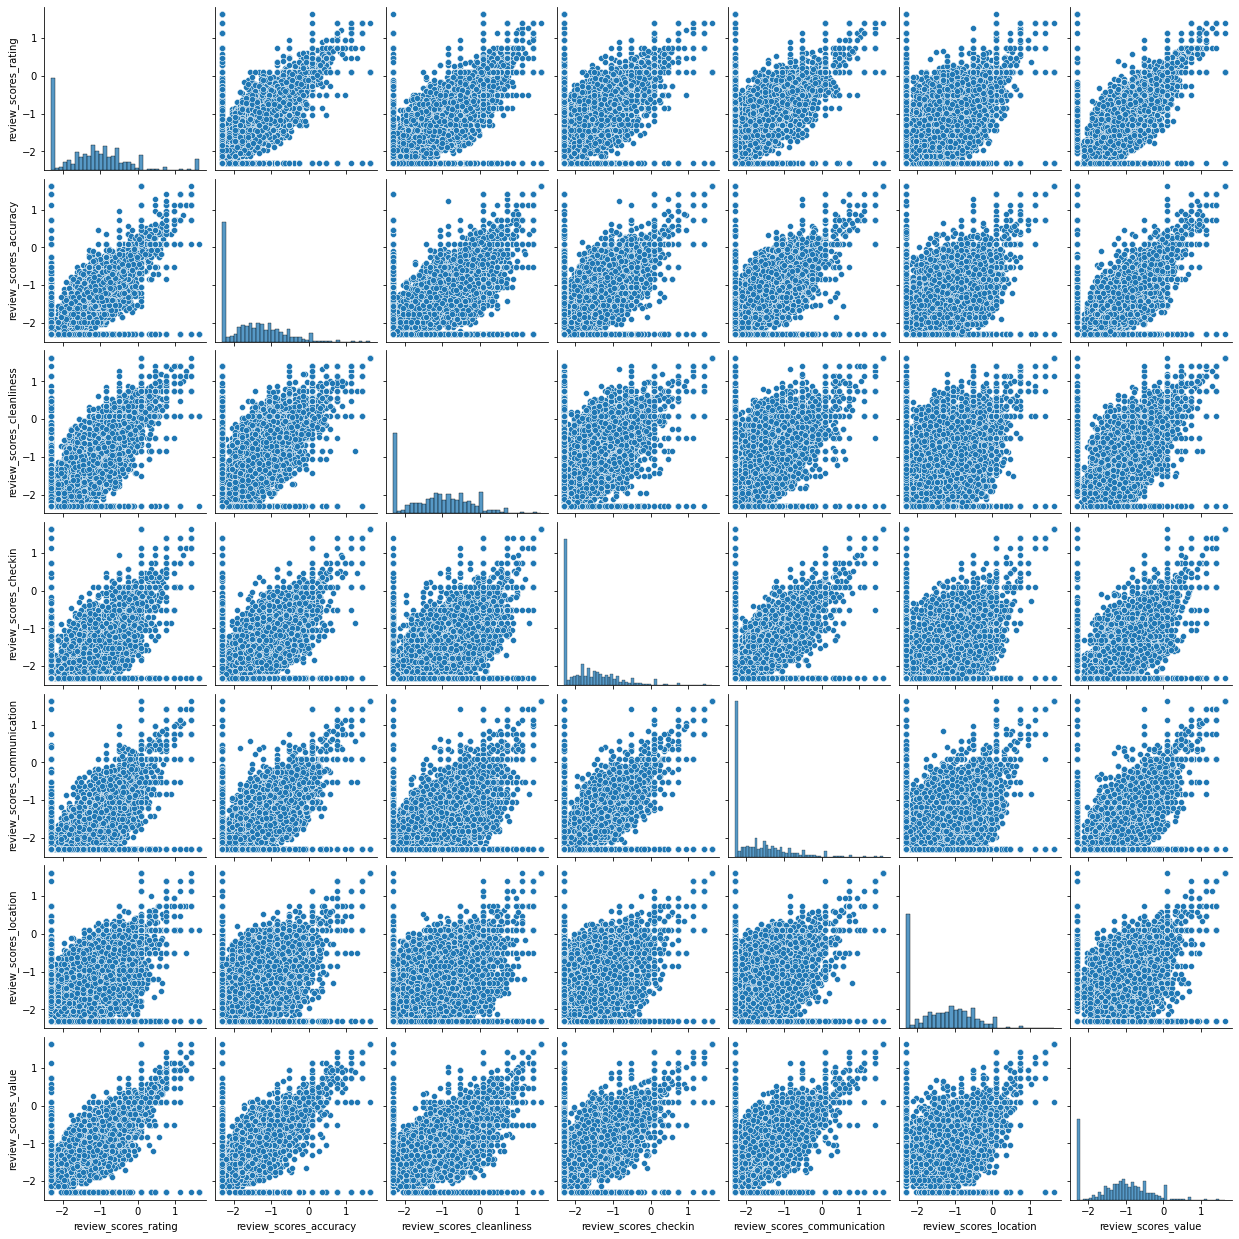

In [18]:
sns.pairplot((5 - df[['review_scores_rating',
        'review_scores_accuracy','review_scores_cleanliness', 
        'review_scores_checkin','review_scores_communication',
        'review_scores_location',
       'review_scores_value']]).apply(lambda a: np.log(a +0.1)))

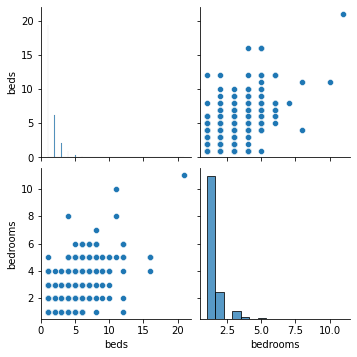

In [19]:
sns.pairplot(df[['beds','bedrooms']])
# Some rooms with an extra bed could cost more - hence while these variables are clearly correlated we will keep them here

# Categorical Representation <a class="anchor" id="fourth-bullet"></a>
It is likely that the host acceptance rate, response time and response rate are not 
useful variables to use as there are too many nan values. Same with the bathrooms text field


They would be likely useful to try in further updates. We will keep them in the mix for current testing purposes

In [20]:
df_categorical = df[categorical_variables]
df_regression = df[regression_variables]
price = df[output_variable]

In [21]:
df_categorical.isnull().sum()


host_identity_verified             25
accommodates                        0
bathrooms_text                     42
room_type                           0
bedrooms                         1915
beds                              139
instant_bookable                    0
neighbourhood_group_cleansed        0
host_has_profile_pic               25
host_response_time              11238
host_is_superhost                  25
dtype: int64

In [22]:
df_regression.isnull().sum()

review_scores_rating            3183
review_scores_accuracy          3669
review_scores_cleanliness       3658
review_scores_checkin           3675
review_scores_communication     3665
review_scores_location          3678
review_scores_value             3679
host_response_rate             11238
host_acceptance_rate           10741
dtype: int64

In [23]:
def categorical_transform(df:pd.Series):
    """
    df: a pandas series object pd.Series - also may work on pd.DataFrame - not tested
    Takes a series with categories with strings, will raise an error for numerical data
    """
    assert df.dtype == 'O'
    # copy the dataframe for convienience
    codes_df = df.copy()
    categories = [category for category in df.unique()
                  if category is not np.nan]
    # assigns categories for the pandas categorical function
    convert_to_codes = pd.Categorical(df, categories).codes.astype('float32')
    convert_to_codes[convert_to_codes ==-1] = np.nan
    # Discarding the nan values, which are assigned as -1 as a default
    
    
    assert len(categories) == np.unique(convert_to_codes[convert_to_codes >=0]).shape[0]
    # check that the number of categories aligns with input number of categories, excluding the nans
    return convert_to_codes
    

In [24]:
df_categorical.host_is_superhost = categorical_transform(df_categorical.host_is_superhost)
df_categorical.host_response_time = categorical_transform(df_categorical.host_response_time)
df_categorical.room_type= categorical_transform(df_categorical.room_type)
df_categorical.bathrooms_text= categorical_transform(df_categorical.bathrooms_text)
df_categorical.host_has_profile_pic = categorical_transform(df_categorical.host_has_profile_pic)
df_categorical.neighbourhood_group_cleansed = categorical_transform(df_categorical.neighbourhood_group_cleansed)
df_categorical.instant_bookable = categorical_transform(df_categorical.instant_bookable)
df_categorical.host_identity_verified = categorical_transform(df_categorical.host_identity_verified)
# these values  are already in interger form and do not need further processing. 
df_categorical.beds +=-1
df_categorical.bedrooms +=-1
df_categorical.accommodates +=-1

C:\Users\user\AppData\Local\Temp\ipykernel_2600\3084042096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical.host_is_superhost = categorical_transform(df_categorical.host_is_superhost)
C:\Users\user\AppData\Local\Temp\ipykernel_2600\3084042096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical.host_response_time = categorical_transform(df_categorical.host_response_time)
C:\Users\user\AppData\Local\Temp\ipykernel_2600\3084042096.py:3: SettingWithCopyWarning: 
A value is tryin

In [25]:
price.price  = (price['price'].str.replace(r'[^-+\d.]', '').astype(float))
df_regression.host_response_rate = (df_regression['host_response_rate'].str.replace(r'[^-+\d.]', '').astype(float))
df_regression.host_acceptance_rate= (df_regression['host_acceptance_rate'].str.replace(r'[^-+\d.]', '').astype(float))



C:\Users\user\AppData\Local\Temp\ipykernel_2600\1228835966.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  price.price  = (price['price'].str.replace(r'[^-+\d.]', '').astype(float))
C:\Users\user\AppData\Local\Temp\ipykernel_2600\1228835966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price.price  = (price['price'].str.replace(r'[^-+\d.]', '').astype(float))
C:\Users\user\AppData\Local\Temp\ipykernel_2600\1228835966.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_regression.host_response_rate = (df_regression['host_response_rate'].str.replace(r'[^-+\d.]', '').astype(float))
C:\Users\user\AppData\Local\Temp\ipykernel_2600\122883596

# Further Exploration of Output Data <a class="anchor" id="fifth-bullet"></a>
Transforming the data is very important for learning in ML. 
We can embed a logarithmic loss / distributional loss by writing a custom loss function, but for simplicity we will just compute the logaritm of the data.

Here we briefly explore some relationships between price and log price and some of the input variances.
This is particularly useful for understanding model sensitivity and if something goes wrong.

Text(0.5, 1.0, 'Log Price')

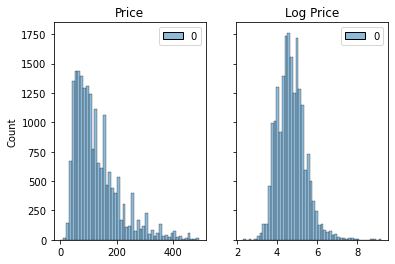

In [26]:
fig, (ax,ax2) = plt.subplots(1,2, figsize =(6,4), sharey =True)
sns.histplot(price.values, ax = ax, bins = np.arange(0,500,10))
sns.histplot(price.apply(np.log).values, ax = ax2, bins =50)
ax.set_title('Price')
ax2.set_title('Log Price')


In [27]:
price.loc[:,'log_price'] = price.apply(np.log)

C:\Users\user\AppData\Local\Temp\ipykernel_2600\165627508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price.loc[:,'log_price'] = price.apply(np.log)


<AxesSubplot:xlabel='bedrooms'>

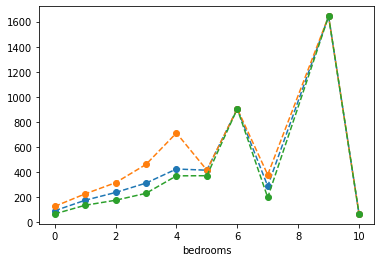

In [28]:
price['price'].groupby(df_categorical.bedrooms).median().plot(ls ='--', marker ='o')
price['price'].groupby(df_categorical.bedrooms).quantile(q =.7).plot(ls ='--', marker ='o')
price['price'].groupby(df_categorical.bedrooms).quantile(q =.3).plot(ls ='--', marker ='o')

<AxesSubplot:xlabel='bedrooms'>

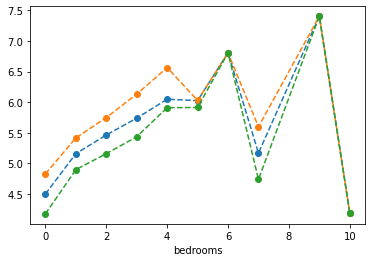

In [29]:
price['log_price'].groupby(df_categorical.bedrooms).median().plot(ls ='--', marker ='o')
price['log_price'].groupby(df_categorical.bedrooms).quantile(q =.7).plot(ls ='--', marker ='o')
price['log_price'].groupby(df_categorical.bedrooms).quantile(q =.3).plot(ls ='--', marker ='o')

## Outliers
There are several issues, as there are few data points when the number of beds exceeds 7.
Again, I should probably remove these outliers as they would likely affect the results obtained

<AxesSubplot:xlabel='beds'>

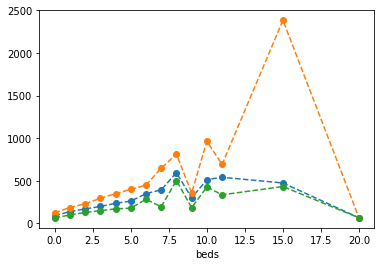

In [30]:
price['price'].groupby(df_categorical.beds).median().plot(ls ='--', marker ='o')
price['price'].groupby(df_categorical.beds).quantile(q =0.7).plot(ls ='--', marker ='o')
price['price'].groupby(df_categorical.beds).quantile(q =0.3).plot(ls ='--', marker ='o')

<AxesSubplot:xlabel='beds'>

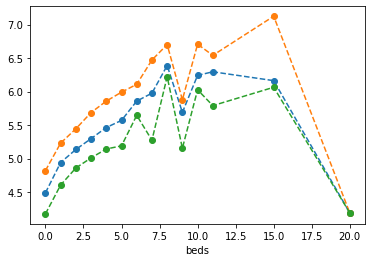

In [31]:
price['log_price'].groupby(df_categorical.beds).median().plot(ls ='--', marker ='o')
price['log_price'].groupby(df_categorical.beds).quantile(q =0.7).plot(ls ='--', marker ='o')
price['log_price'].groupby(df_categorical.beds).quantile(q =0.3).plot(ls ='--', marker ='o')

<AxesSubplot:xlabel='neighbourhood_group_cleansed'>

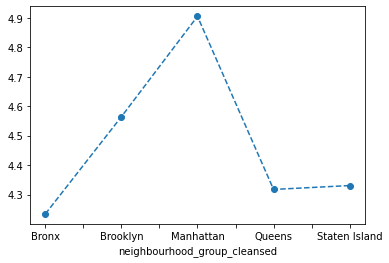

In [32]:
price.log_price.groupby(df.neighbourhood_group_cleansed).median().plot(ls ='--', marker ='o')

In [33]:
price.log_price.groupby(df.bathrooms_text).mean().index

Index(['0 baths', '0 shared baths', '1 bath', '1 private bath',
       '1 shared bath', '1.5 baths', '1.5 shared baths', '2 baths',
       '2 shared baths', '2.5 baths', '2.5 shared baths', '3 baths',
       '3 shared baths', '3.5 baths', '3.5 shared baths', '4 baths',
       '4 shared baths', '4.5 baths', '5 baths', '5.5 baths', '6 baths',
       'Half-bath', 'Private half-bath', 'Shared half-bath'],
      dtype='object', name='bathrooms_text')

### Investigating relationships with bath size could be interesting.
1. Here we will not use baths, it appears that there is a good relationship for baths, but not so good for shared baths.
While in practise I'd investigte further - I'll leave it hear. 

[Text(0, 0, '0 baths'),
 Text(1, 0, '0 shared baths'),
 Text(2, 0, '1 bath'),
 Text(3, 0, '1 private bath'),
 Text(4, 0, '1 shared bath'),
 Text(5, 0, '1.5 baths'),
 Text(6, 0, '1.5 shared baths'),
 Text(7, 0, '2 baths'),
 Text(8, 0, '2 shared baths'),
 Text(9, 0, '2.5 baths'),
 Text(10, 0, '2.5 shared baths'),
 Text(11, 0, '3 baths'),
 Text(12, 0, '3 shared baths'),
 Text(13, 0, '3.5 baths'),
 Text(14, 0, '3.5 shared baths'),
 Text(15, 0, '4 baths'),
 Text(16, 0, '4 shared baths'),
 Text(17, 0, '4.5 baths'),
 Text(18, 0, '5 baths'),
 Text(19, 0, '5.5 baths'),
 Text(20, 0, '6 baths'),
 Text(21, 0, 'Half-bath'),
 Text(22, 0, 'Private half-bath'),
 Text(23, 0, 'Shared half-bath')]

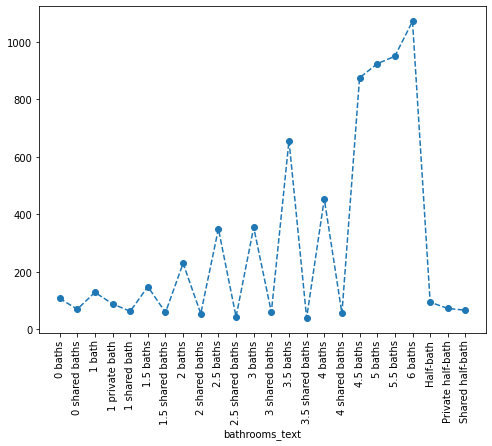

In [34]:
fig, ax = plt.subplots(figsize =(8,6))
ax = price.price.groupby(df.bathrooms_text).median().plot(ls ='--', marker ='o',ax =ax)
ticks =price.price.groupby(df.bathrooms_text).median().index
ax.set_xticks(np.arange(len(ticks)))
ax.set_xticklabels(ticks, rotation =90)

# Saving Data <a class="anchor" id="sixth-bullet"></a>
Change each categorical variable to a sequence - this is required for using for deep learning algorithms

In [35]:
df_categorical.to_csv('./preprocessed/categorical_raw.csv')
df_regression.to_csv('./preprocessed/regression_raw.csv')

In [36]:
def rename_categorical(df, col_name):
    output = pd.get_dummies(df[col_name])
    output[df[col_name].isnull()] = np.nan
    output.columns = [col_name+'_' +str(int(col)) for col in output.columns]
    return output

In [37]:
categorical_postprocessed = pd.concat([rename_categorical(df_categorical, col) for col in df_categorical.columns], axis =1)
categorical_postprocessed.dropna()

,host_identity_verified_0,host_identity_verified_1,accommodates_0,accommodates_1,accommodates_2,accommodates_3,accommodates_4,accommodates_5,accommodates_6,accommodates_7,...,neighbourhood_group_cleansed_3,neighbourhood_group_cleansed_4,host_has_profile_pic_0,host_has_profile_pic_1,host_response_time_0,host_response_time_1,host_response_time_2,host_response_time_3,host_is_superhost_0,host_is_superhost_1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19990,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
19991,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
19994,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
19996,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [38]:
categorical_postprocessed.to_csv('./preprocessed/categorical_binary.csv')

In [39]:
transformed_cols = ['review_scores_rating',
        'review_scores_accuracy','review_scores_cleanliness', 
        'review_scores_checkin','review_scores_communication',
        'review_scores_location',
       'review_scores_value']
for col in transformed_cols:
    df_regression['transformed_' + col] = df_regression[col].apply(lambda a: np.log(5-a +0.001))

C:\Users\user\AppData\Local\Temp\ipykernel_2600\1414302171.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['transformed_' + col] = df_regression[col].apply(lambda a: np.log(5-a +0.001))
C:\Users\user\AppData\Local\Temp\ipykernel_2600\1414302171.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['transformed_' + col] = df_regression[col].apply(lambda a: np.log(5-a +0.001))
C:\Users\user\AppData\Local\Temp\ipykernel_2600\1414302171.py:7: SettingWithCopyWarning: 
A value is try

<AxesSubplot:xlabel='transformed_review_scores_accuracy', ylabel='Count'>

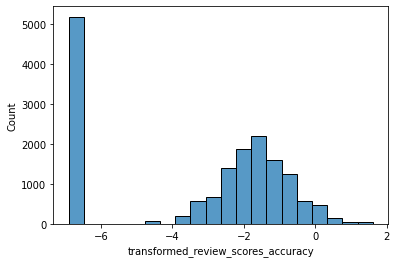

In [40]:
sns.histplot(df_regression['transformed_review_scores_accuracy'])

In [41]:
df_regression.to_csv('./preprocessed/regression_transformed.csv')
price.to_csv('./preprocessed/price.csv')

# Assembling the training and testing data periods
1. In this case we use the first 70% of the data for training.
2. the last 30% is used for testing and validation

In [42]:
index = pd.DataFrame(data =df.index, index =df.index, columns =['dset'])

In [43]:
index.iloc[0:np.int(0.7 * len(index))] = 'train'
index.iloc[np.int(0.7 * len(index)):np.int(0.85 * len(index))] = 'validation'
index.iloc[np.int(0.85 * len(index)):] = 'test'

In [44]:
index.to_csv('./preprocessed/benchmark_datasets_index.csv')